## Boosting and Pipelines

### Objectives

- Understanding how we can create a streamline of procedures (Pipelines)

- What is the use of such practices.

- Boosting methods - Specifically Gradient and Adaboost

- Implementation of GradientBoostClassifier with fine-tuning with gridsearch.


### Pipelines

__Q:__ What is a pipeline?

[sklearn - documentation](https://scikit-learn.org/stable/modules/compose.html#pipeline)

> Transformers (scaling, preprocessing, feature selection etc.) are usually combined with classifiers, regressors or other estimators to build a composite estimator. The most common tool is a Pipeline.

__Q__: Why should we use pipelines?

    - Convenience: You only have to call fit and predict once on your data to fit a whole sequence of estimators.
    - Joint parameter selection: You can grid search over parameters of all estimators in the pipeline at once.
    - Safety: Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.
    
    


In [1]:
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
## load the dataset 
## Source: https://www.kaggle.com/uciml/pima-indians-diabetes-database/download
df = pd.read_csv('data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.shape

(768, 9)

In [4]:
## Let's use describe method to see if there is anything suspicious
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
## Now let's use info method
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
## separate target variable from features
target = df.Outcome
df.drop('Outcome', axis=1, inplace=True)

In [7]:
## Let's see the distribution of 1's and 0's
np.unique(target, return_counts= True)

(array([0, 1]), array([500, 268]))

In [8]:
## Split data into test train
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.20, stratify = target)

Note that in this problem it makes sense to focus on recall score as we don't want to  misclassify patients with diabetes.

Recall score = $\frac{tp}{(tp + fn)}$


In [9]:
## First let's fit a logistic regression model to see the baseline
## we will also use pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

## we will apply standard scaling to Logistic regression
## because we might want to use regularization

from sklearn.preprocessing import StandardScaler

In [10]:
## ll estimators in a pipeline, except the last one,
## must be transformers (i.e. must have a transform method). 
## The last estimator may be any type (transformer, classifier, etc.)

pipe = Pipeline([('ss', StandardScaler()),
                 ('log_reg', LogisticRegression(random_state=123,
                                                max_iter = 1000, 
                                                solver = 'saga'))])
# each transformer in the pipeline is a tuple with (nickname, transformer)

In [12]:
## we can access to a particular step in the pipeline

print(pipe.steps[0])

print(pipe['log_reg']) # similar to a dictionary

('ss', StandardScaler(copy=True, with_mean=True, with_std=True))
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


In [13]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve


train_scores, valid_scores = validation_curve(pipe, X_train, y_train, "log_reg__C",
                                              np.logspace(-7, 3, 3),
                                              cv=5)

In [14]:
## we can call fit method with pipeline 
## we can call them with a gridsearch

## let's use fit method from pipeline
pipe.fit(X_train, y_train)

## We can access the trained estimator from pipe
# will just do the logistic regression. Not the StandardScaler()
pipe['log_reg'].predict(X_train);

## can also do
pipe.predict(X_train)

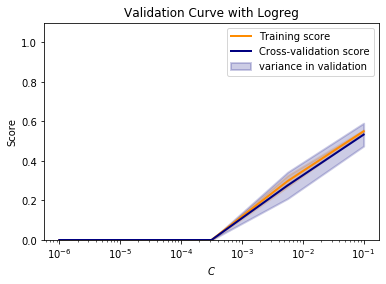

In [16]:

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    pipe, X_train, y_train, param_name="log_reg__C", param_range=param_range,
    scoring="recall", n_jobs=1, cv= 5)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Logreg")
plt.xlabel(r"$C$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw, label = 'variance in validation')
plt.legend(loc="best")
plt.show()

In [21]:
## to find a best value for the C
## let's use GridSearchCV

from sklearn.model_selection import GridSearchCV
grid = [{'log_reg__C': np.logspace(-2,2,10, base = 10.0) # define ranges for C
         ,'log_reg__penalty': ['l1', 'l2'], 'ss__with_mean': [False,True]}]

gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='recall' # add the scoring that is the focus of your question
                  ,cv=5, verbose=1, n_jobs=-1)

gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished


In [22]:
# Best accuracy
print('Best accuracy: %.3f' % gridsearch.best_score_)

# Best params
print('\nBest params:\n', gridsearch.best_params_)

Best accuracy: 0.552

Best params:
 {'log_reg__C': 1.6681005372000592, 'log_reg__penalty': 'l1', 'ss__with_mean': False}


**Still don't check TEST data! Only until you arrive at your best model!**

### Boosting Algorithms

__Q:__ What is boosting?

 - Recall that random forest algorithm uses boosting aggregation (bagging) to decrease the variance of individual trees.
 - Boosting ~ Bagging 
      - Bagging: Trees grow parallel
      - Boosting: Trees grow sequentially
 - Idea is to create a slow learner.

- Usually trees are good for these (bagging,boosting) types of algorithms since they are simple and interpretable.
- Recall that in bagging we did bootstrapping in boosting we don't do bootstrapping instead we modify the dataset at each step.

__important parameters__(with sklearn notation)

__n_estimators:__ # of trees to use in the procedure


__learning_rate:__ (Shrinkage parameter)

> The shrinkage parameter $\lambda$, a small positivenumber.This controls the rate at which boosting learns. Typical values are 0.01 or 0.001, and the right choice can depend on the problem. Very small  $\lambda$ can require using a very large value of B in order to achieve good performance


<img src="img/boosting_algorithm.png" width=450, height=450> 

__max_depth, max_leaf_nodes etc,__ (The number of splits in each trees)

> Often d = 1 works well, in which case each tree is called a _stump_, consisting of a single split. In this case, the boosted ensemble is fitting an additive model, since each term involves only a single variable. More generally d is the interaction depth, and controls the interaction order of the boosted model, since d splits can involve at most d variables.

[Gradient Boosting in sklearn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting)

In [18]:
## Now let's investigate the performance of Adaboost and GradientBoost
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
## let's see some of the parameters of the Gradient Boosting
?GradientBoostingClassifier

In [19]:
gbc = GradientBoostingClassifier(random_state= 103019,
                                 validation_fraction=0.1, 
                                 n_iter_no_change= 5, 
                                 tol = 0.001)
# subsample: bootstrapping the data and giving each tree a subsample of data
# max_leaf_nodes: pruning the tree depth. Better to use this instead of 'max_depth'

In [23]:
## Let's use a gridsearch to find best parameters for GradientBoost

params = {'n_estimators' : [100, 200, 300],
         'learning_rate' : np.logspace(-3, -1, 5),
         'max_leaf_nodes': [3,5,7,9],
         'subsample': [0.2, 0.5, 0.7, 0.9], 
         'max_features':[0.5,1]}

gs = GridSearchCV(estimator = gbc, 
                  param_grid = params,
                  cv = 5, 
                  scoring= 'recall',
                  verbose = 1,
                  n_jobs= -1)

gs.fit(X_train, y_train);

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 380 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 799 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 1149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1599 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2363 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2393 out of 2400 | elapsed:  2.0min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.0min finished


### Some practical tips for Gradient Boost

- Apparently max_leaf_nodes = k gives similar results to max_depth = k-1 but according to sklearn documentation max_leaf_nodes works faster. So you might want to use max_leaf_nodes for bigger projects.

- Again according to sklearn documentation, smaller learning rate gives better test_scores but you might want to put more estimators if you set the learning rate small.

- As it is mentioned above, when small learning rate is used we might increase the number of estimators. To prevent unneccesarry computing then we can put some early stopping criteria by the parameters: n_iter_change, min_impurity_decrease or tol.

- It looks like subsampling with shrinkage method (learning rate) might give better results. In this case, out of bag test scoring is also become available. Note that you can access these by oob_improvement method.

- Using a small max_features value can significantly decrease the runtime.

For more: 
[sklearn documentation - gradientboost](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

In [24]:
print(gs.best_score_)
print(gs.best_estimator_)

0.5747508305647842
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.5, max_leaf_nodes=7,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=103019, subsample=0.9, tol=0.001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [25]:
## let's see the best_estimator's test performance
best_estimator = gs.best_estimator_
y_pred = best_estimator.predict(X_test)


## import recall_score from sklearn
from sklearn.metrics import recall_score

print(recall_score(y_test, y_pred))

## similarly log_reg predictor would give

log_reg_best = gridsearch.best_estimator_
y_pred_log = log_reg_best.predict(X_test)

print(recall_score(y_test, y_pred_log))

0.5925925925925926
0.5740740740740741


In [26]:
y_train_pred = best_estimator.predict(X_train)

print(recall_score(y_train, y_train_pred))

## try the same thing with log_reg_best: Do you expect better score?

0.6542056074766355


In [ ]:
## Try Adaboost algorithm and XGboost here
## Use gridsearch or RandomSearchCV to fine-tune parameters.